In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  # For Fancy PCA (data augmentation)
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import plotly.express as px
import lasio as ls
import missingno as mno

In [59]:
import warnings

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.metrics")

In [60]:
import os

np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Data Preparation

In [61]:
vmm_df = pd.read_csv('data/combined_df_VMM.csv')

In [62]:
vmm_df.head()

,Well,Depth,Clay,Quartz,Carbonates,TOC,Formation,Sonic,GammaRay,NeutronPorosity,Resistivity,Density,Photoelectric,AvgPorosity,RHOMAA,UMA,GR_Dens,PEF_Dens
0,Coyote-1,7200.0,48.675996,49.526372,1.797632,2.672507,El Salto,80.00674,61.79465,0.24560,21.25296,2.59795,5.7005,0.200711,2.999215,18.402937,23.785927,2.194230
1,Coyote-1,7214.5,28.392838,57.018752,14.588410,3.218767,El Salto,74.89855,109.48310,0.25430,36.39704,2.46675,8.7508,0.226427,2.896073,27.757992,44.383541,3.547502
2,Coyote-1,7215.0,82.689167,16.548721,0.762112,3.976217,El Salto,75.93570,106.21910,0.25615,42.38375,2.47125,8.9295,0.227161,2.903694,28.406222,42.981932,3.613354
3,Coyote-1,7232.0,82.195781,17.577069,0.227150,8.061749,El Salto,76.33705,115.05360,0.28790,184.61350,2.37395,7.7611,0.265648,2.870970,24.908553,48.465048,3.269277
4,Coyote-1,7240.0,39.656924,43.132829,17.210247,4.956246,El Salto,77.64470,117.64320,0.18490,51.75293,2.35775,7.9863,0.191456,2.679253,23.170002,49.896384,3.387255


In [63]:
catatumbo_df = pd.read_csv('data/combined_df_catatumbo.csv')

In [64]:
catatumbo_df.head()

,Depth,Clay,Quartz,Carbonates,GammaRay,NeutronPorosity,Resistivity,Density,GR_Dens,Porosity,Sonic,TOC,AvgPorosity,Photoelectric,RHOMAA,UMA,PEF_Dens,Well
0,3969.75,6.249976,37.376395,56.373629,78.643553,0.010161,1170.551553,2.642048,29.766132,0.010814,58.444386,3.899055,0.010488,3.247959,2.659452,8.666917,1.229334,Cerro Gordo
1,3970.80,7.630743,45.047386,47.321871,78.480317,0.008292,1167.594647,2.645179,29.669185,0.008928,57.963118,3.874733,0.008610,3.412304,2.659468,9.100204,1.290009,Cerro Gordo
2,3971.60,3.498313,73.719427,22.782260,80.599120,0.007463,1021.735200,2.645330,30.468451,0.008837,57.924186,3.741526,0.008150,3.609310,2.658850,9.622163,1.364408,Cerro Gordo
3,3972.10,11.433496,65.508263,23.058241,78.569370,0.005483,1051.229209,2.648003,29.671184,0.007227,58.080087,3.776628,0.006355,3.875708,2.658543,10.325329,1.463635,Cerro Gordo
4,3972.50,9.537947,41.145604,49.316449,69.597500,0.004168,1083.491644,2.650692,26.256351,0.005607,58.417025,3.821687,0.004888,3.718010,2.658800,9.901250,1.402656,Cerro Gordo


In [65]:
# combine both dataframes
combined_df = pd.concat([vmm_df, catatumbo_df], ignore_index=True)

In [66]:
combined_df.head()

,Well,Depth,Clay,Quartz,Carbonates,TOC,Formation,Sonic,GammaRay,NeutronPorosity,Resistivity,Density,Photoelectric,AvgPorosity,RHOMAA,UMA,GR_Dens,PEF_Dens,Porosity
0,Coyote-1,7200.0,48.675996,49.526372,1.797632,2.672507,El Salto,80.00674,61.79465,0.24560,21.25296,2.59795,5.7005,0.200711,2.999215,18.402937,23.785927,2.194230,NaN
1,Coyote-1,7214.5,28.392838,57.018752,14.588410,3.218767,El Salto,74.89855,109.48310,0.25430,36.39704,2.46675,8.7508,0.226427,2.896073,27.757992,44.383541,3.547502,NaN
2,Coyote-1,7215.0,82.689167,16.548721,0.762112,3.976217,El Salto,75.93570,106.21910,0.25615,42.38375,2.47125,8.9295,0.227161,2.903694,28.406222,42.981932,3.613354,NaN
3,Coyote-1,7232.0,82.195781,17.577069,0.227150,8.061749,El Salto,76.33705,115.05360,0.28790,184.61350,2.37395,7.7611,0.265648,2.870970,24.908553,48.465048,3.269277,NaN
4,Coyote-1,7240.0,39.656924,43.132829,17.210247,4.956246,El Salto,77.64470,117.64320,0.18490,51.75293,2.35775,7.9863,0.191456,2.679253,23.170002,49.896384,3.387255,NaN


In [67]:
features = ['GammaRay', 'Sonic', 'Density', 'Resistivity', 'NeutronPorosity', 'Photoelectric']
target = ['Carbonates', 'Clay', 'Quartz']

In [68]:
# only keep the features and target columns
columns_to_keep = ['Depth'] + features + target
combined_df = combined_df[columns_to_keep]

<Axes: >

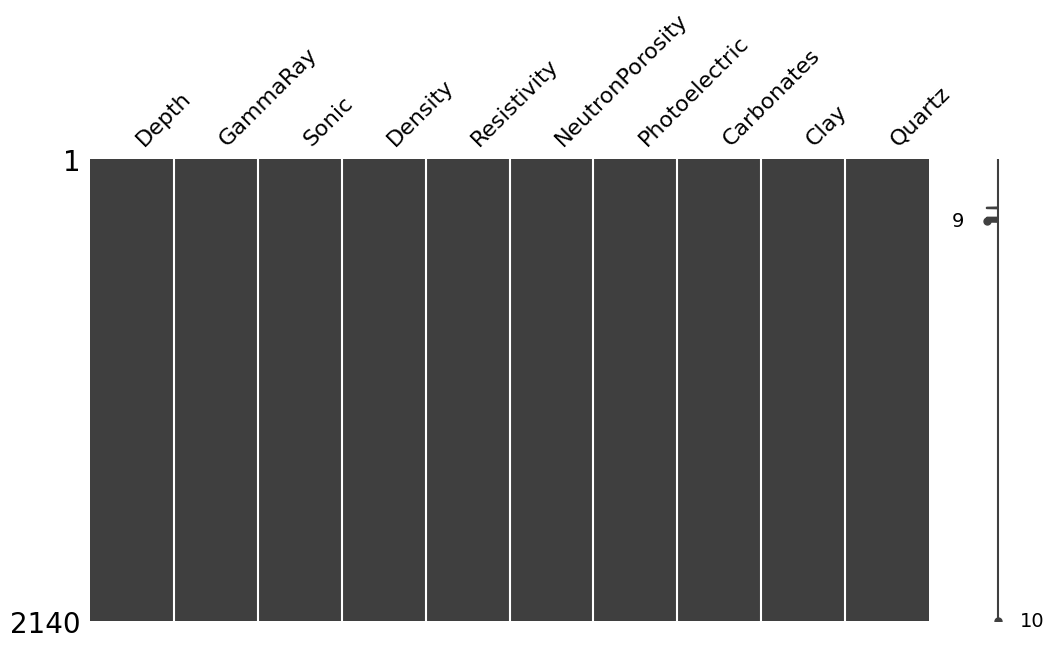

In [69]:
# check nans of combined_df with msno
mno.matrix(combined_df, figsize=(12, 6))    

In [14]:
# fill nans with interpolation
combined_df = combined_df.interpolate(method='linear', limit_direction='both')

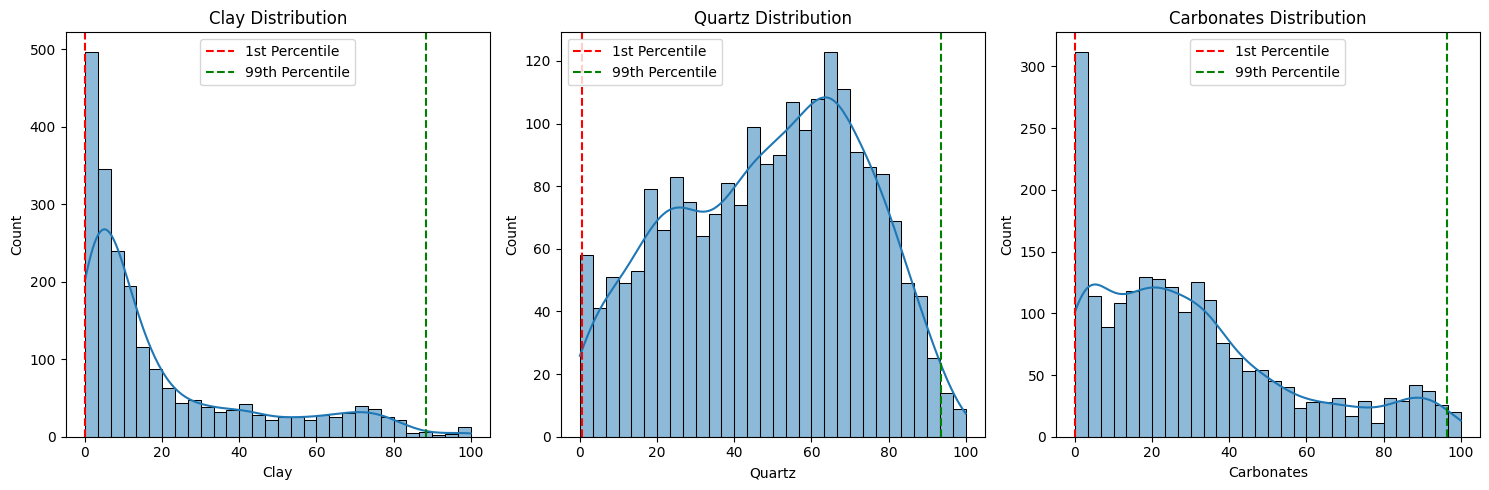

In [15]:
# show percentiles 1 and 99 for each clay, quartz, and carbonate in an histogram

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['Clay', 'Quartz', 'Carbonates']):
    sns.histplot(combined_df[feature], bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f"{feature} Distribution")
    ax[i].axvline(combined_df[feature].quantile(0.01), color='red', linestyle='--', label='1st Percentile')
    ax[i].axvline(combined_df[feature].quantile(0.99), color='green', linestyle='--', label='99th Percentile')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [16]:
combined_df.columns

Index(['GammaRay', 'Sonic', 'Density', 'Resistivity', 'NeutronPorosity',
       'Photoelectric', 'Carbonates', 'Clay', 'Quartz'],
      dtype='object')

In [17]:
for col in ['Clay', 'Quartz', 'Carbonates']:
    p1 = combined_df[col].quantile(0.01)
    p99 = combined_df[col].quantile(0.99)
    combined_df = combined_df[(combined_df[col] >= p1) & (combined_df[col] <= p99)]

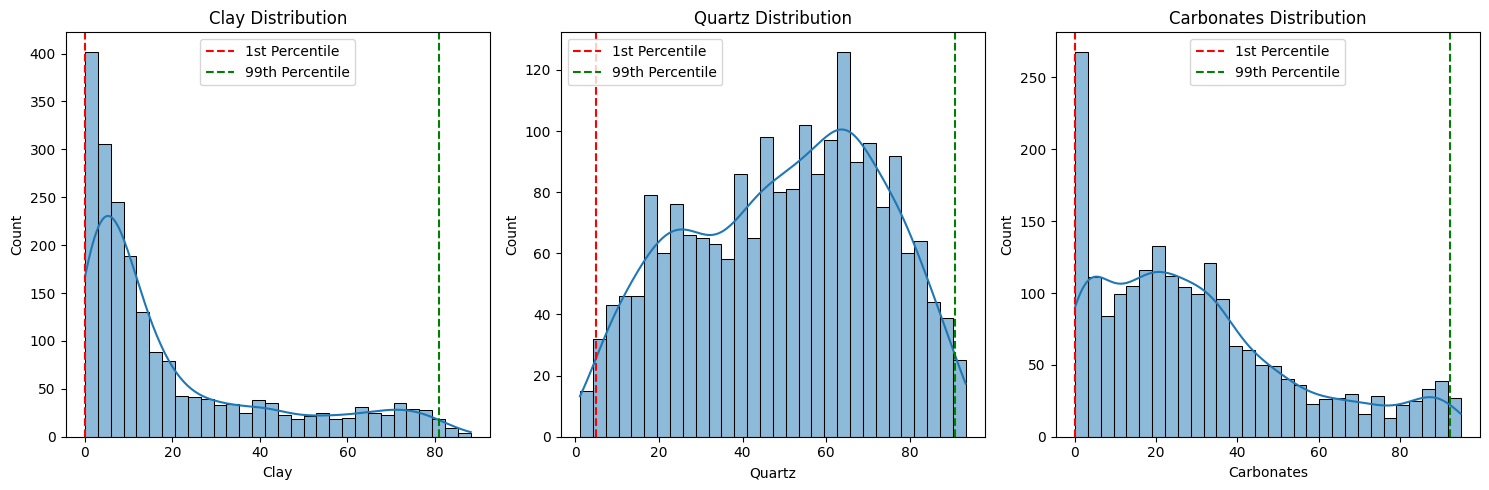

In [18]:
# show percentiles 1 and 99 for each clay, quartz, and carbonate in an histogram

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['Clay', 'Quartz', 'Carbonates']):
    sns.histplot(combined_df[feature], bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f"{feature} Distribution")
    ax[i].axvline(combined_df[feature].quantile(0.01), color='red', linestyle='--', label='1st Percentile')
    ax[i].axvline(combined_df[feature].quantile(0.99), color='green', linestyle='--', label='99th Percentile')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd

# Define features (well logs) and target variables (minerals)
features = ['GammaRay', 'Sonic', 'Density', 'Resistivity', 'NeutronPorosity', 'Photoelectric']
target = ['Carbonates', 'Clay', 'Quartz']

X = combined_df[features]
y = combined_df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data if needed
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Convert the target columns to numeric
y_train['Carbonates'] = pd.to_numeric(y_train['Carbonates'], errors='coerce')
y_train['Clay'] = pd.to_numeric(y_train['Clay'], errors='coerce')
y_train['Quartz'] = pd.to_numeric(y_train['Quartz'], errors='coerce')

# Check if the conversion worked
print(y_train.dtypes)

Carbonates    float64
Clay          float64
Quartz        float64
dtype: object


<Axes: >

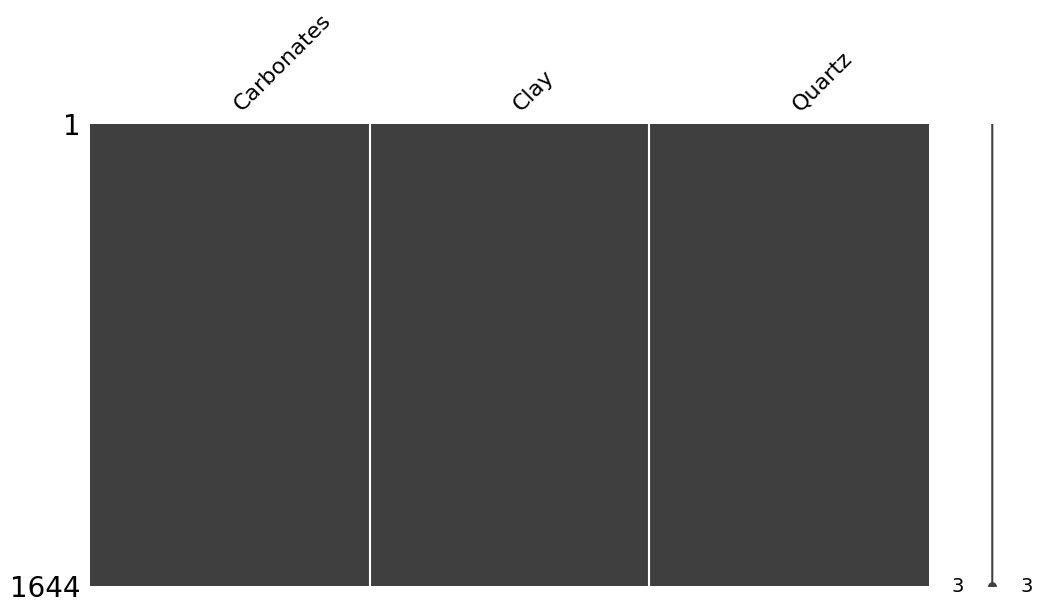

In [21]:
import missingno as mno

# Visualize missing values in the training set
mno.matrix(y_train, figsize=(12, 6))

## Build and train the model with weights

In [22]:
import numpy as np
import pandas as pd

# Calculate weights based on 15-bin histogram for each target
def calculate_weights(y, bins=15):
    # Calculate the bin frequencies for each target variable
    weights = np.zeros(y.shape)
    for i, col in enumerate(y.columns):
        hist, bin_edges = np.histogram(y[col], bins=bins)
        max_freq = np.max(hist)
        bin_weights = np.zeros(len(y[col]))

        # Assign weights based on the inverse of the bin frequency
        for j in range(bins):
            bin_mask = (y[col] >= bin_edges[j]) & (y[col] < bin_edges[j+1])
            freq = hist[j]
            if freq > 0:
                bin_weights[bin_mask] = max_freq / freq

        # If the value equals the last bin edge (e.g., max value), set the weight
        bin_weights[y[col] == bin_edges[-1]] = max_freq / hist[-1]
        weights[:, i] = bin_weights

    return weights

# Calculate weights for the training set
sample_weights = calculate_weights(y_train)

# Check the shape of the weights array
print(f"Shape of sample weights: {sample_weights.shape}")

Shape of sample weights: (1644, 3)


In [23]:
pos = np.random.permutation(y_train.shape[0])

In [24]:
from keras import models, layers, regularizers

# Define the model architecture
def create_improved_model(dropout_rate=0.3, l2_reg=0.001, neurons=64, optimizer='adam', 
                         num_layers=4, activation_type='leaky_relu', use_residual=False):
    """
    Modelo mejorado con arquitectura flexible para predicción mineralógica
    
    Args:
        num_layers: Número de capas ocultas (3-6 recomendado)
        activation_type: 'leaky_relu', 'elu', 'swish'
        use_residual: Habilitar skip connections para redes más profundas
    """
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
    
    # Definir arquitectura adaptativa
    layer_sizes = []
    for i in range(num_layers):
        # Reducción más suave y adaptativa
        reduction_factor = (2 ** i) if i < 3 else (2 ** 3)  # Limitar reducción excesiva
        layer_size = max(neurons // reduction_factor, 16)  # Mínimo 16 neuronas
        layer_sizes.append(layer_size)
    
    # Construir capas ocultas
    for i, layer_size in enumerate(layer_sizes):
        # Capa densa con regularización
        model.add(layers.Dense(layer_size, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        
        # Activación flexible
        if activation_type == 'leaky_relu':
            model.add(layers.LeakyReLU(alpha=0.1))
        elif activation_type == 'elu':
            model.add(layers.ELU(alpha=1.0))
        elif activation_type == 'swish':
            model.add(layers.Activation('swish'))
        
        # Dropout adaptativo (menos en capas finales)
        dropout_adaptive = dropout_rate * (0.8 if i == len(layer_sizes)-1 else 1.0)
        model.add(layers.Dropout(dropout_adaptive))
    
    # Capa de salida con mejor inicialización
    model.add(layers.Dense(3, activation='linear', 
                          kernel_initializer='glorot_uniform',
                          bias_initializer='zeros'))
    
    # Compilar con métricas adicionales
    model.compile(
        optimizer=optimizer, 
        loss='mae',
        metrics=['mse', 'mae']  # Para mejor monitoreo
    )
    return model
# Initialize and train the model with sample weights
updated_model = create_improved_model()

# For each target variable, assign the corresponding column of weights
history = updated_model.fit(X_train_scaled[pos], y_train.iloc[pos], 
                            sample_weight=sample_weights.mean(axis=1),  # Average weights for multi-output
                            validation_data=(X_test_scaled, y_test), 
                            shuffle=True,
                            epochs=100, batch_size=32, verbose=1)

Epoch 1/100


c:\Users\juanc\anaconda3\envs\ICP_ML\lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\juanc\anaconda3\envs\ICP_ML\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 105.0557 - mae: 33.5248 - mse: 1838.6411 - val_loss: 33.3941 - val_mae: 33.3014 - val_mse: 1783.9524
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.8099 - mae: 33.1307 - mse: 1809.4807 - val_loss: 33.2515 - val_mae: 33.1589 - val_mse: 1771.6312
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102.4528 - mae: 32.7084 - mse: 1777.7205 - val_loss: 33.0357 - val_mae: 32.9431 - val_mse: 1755.0930
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101.1916 - mae: 32.3199 - mse: 1747.7557 - val_loss: 32.7214 - val_mae: 32.6287 - val_mse: 1731.0155
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.4588 - mae: 31.7581 - mse: 1707.7766 - val_loss: 32.2530 - val_mae: 32.1602 - val_mse: 1695.5193
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.8027 - mae: 31.2433 - mse: 1668.6155 - val_loss: 31.6207 - val_mae: 31.5276 - val_mse: 1648.8325
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the test set
y_pred = updated_model.predict(X_test_scaled)

# Define function to calculate normalized RMSE and nMAE
def calculate_normalized_error(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    nmae = mae / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    return nrmse, nmae, r2

# Calculate metrics for Calcite
nrmse_calcite, nmae_calcite, r2_calcite = calculate_normalized_error(y_test['Carbonates'], y_pred[:, 0])

# Calculate metrics for Clay
nrmse_clay, nmae_clay, r2_clay = calculate_normalized_error(y_test['Clay'], y_pred[:, 1])

# Calculate metrics for Quartz
nrmse_quartz, nmae_quartz, r2_quartz = calculate_normalized_error(y_test['Quartz'], y_pred[:, 2])

# Print final metrics
print(f"nRMSE for Calcite: {nrmse_calcite:.2f}, nMAE: {nmae_calcite:.2f}, R²: {r2_calcite:.2f}")
print(f"nRMSE for Clay: {nrmse_clay:.2f}, nMAE: {nmae_clay:.2f}, R²: {r2_clay:.2f}")
print(f"nRMSE for Quartz: {nrmse_quartz:.2f}, nMAE: {nmae_quartz:.2f}, R²: {r2_quartz:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
nRMSE for Calcite: 0.23, nMAE: 0.16, R²: 0.24
nRMSE for Clay: 0.41, nMAE: 0.15, R²: -1.39
nRMSE for Quartz: 0.20, nMAE: 0.16, R²: 0.32


In [26]:
# Verify the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Print a few sample predictions vs actual values
print("Sample Predictions vs Actuals:")
print(f"Predicted Calcite: {y_pred[:5, 0]}")
print(f"Actual Calcite: {y_test['Carbonates'].values[:5]}")

Shape of y_test: (411, 3)
Shape of y_pred: (411, 3)
Sample Predictions vs Actuals:
Predicted Calcite: [38.433334 19.324686 30.140375 20.118494 25.749315]
Actual Calcite: [81.81324057 12.1383511  17.57290068 17.24252125 38.26831809]


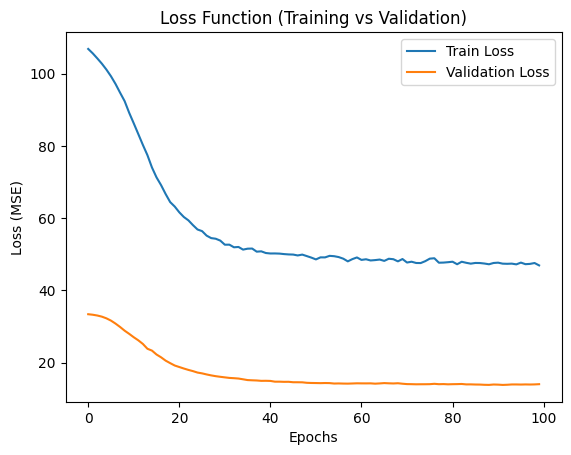

In [27]:
# Plot loss function
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function (Training vs Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

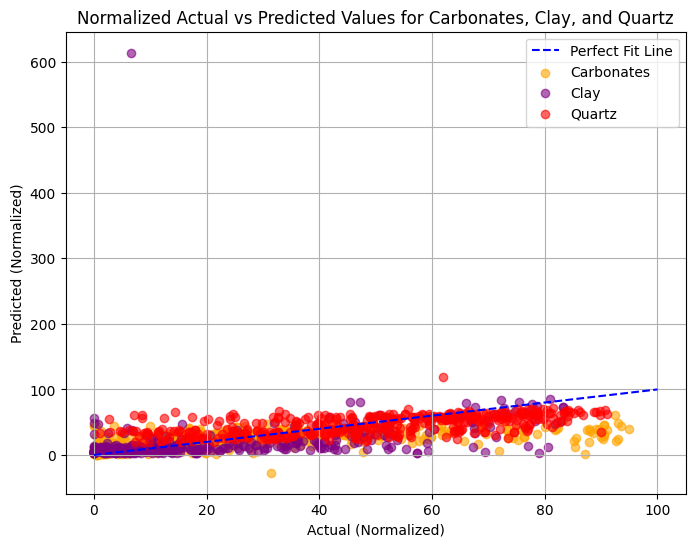

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Create the plot
plt.figure(figsize=(8, 6))


# Plot the perfect fit line (0-1 diagonal)
plt.plot([0, 100], [0, 100], 'b--', label='Perfect Fit Line')

# Plot for Calcite
plt.scatter(y_test['Carbonates'], y_pred[:, 0], label='Carbonates', color='orange', alpha=0.6)

# Plot for Clay
plt.scatter(y_test['Clay'], y_pred[:, 1], label='Clay', color='purple', alpha=0.6)

# Plot for Quartz
plt.scatter(y_test['Quartz'], y_pred[:, 2], label='Quartz', color='red', alpha=0.6)

# Add labels and title
plt.xlabel('Actual (Normalized)')
plt.ylabel('Predicted (Normalized)')
plt.title('Normalized Actual vs Predicted Values for Carbonates, Clay, and Quartz')

# Add legend and show the plot
plt.legend()
plt.grid(True)
plt.show()

### PCA analysis and augmentation

In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Set random seed for NumPy
np.random.seed(42)

# Define the number of synthetic samples per original sample
num_samples = 5  # Adjust as needed

# Separate features and labels
features = ['GammaRay', 'Sonic', 'Density', 'Resistivity', 'NeutronPorosity', 'Photoelectric']
labels = ['Carbonates', 'Clay', 'Quartz']

X = combined_df[features]
y = combined_df[labels]

# Normalize the features separately
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

# Normalize the labels separately
label_scaler = MinMaxScaler()
y_scaled = label_scaler.fit_transform(y)

# Split the dataset into training and testing sets with a fixed random state
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42
)

# Combine scaled features and labels for PCA
combined_train = np.hstack((X_train, y_train))

# Check the shape of the combined dataset
print(f"Shape of combined_train: {combined_train.shape}")

# Apply PCA to the combined training dataset
n_components = min(combined_train.shape[0], combined_train.shape[1])  # Minimum of samples or features
pca = PCA(n_components=n_components, random_state=42)
combined_train_pca = pca.fit_transform(combined_train)

# Function for augmenting data using Fancy PCA
def fancy_pca_augment(combined_data, num_samples, pca, noise_scale=0.1, seed=42):
    augmented_data = []
    rng = np.random.default_rng(seed)  # Use NumPy's Generator for random number generation
    for i in range(num_samples):
        # Add noise to the principal components
        noise = rng.normal(scale=noise_scale, size=combined_data.shape)
        augmented_pca = combined_data + noise
        # Transform back to the original space
        augmented_data.append(pca.inverse_transform(augmented_pca))
    return np.vstack(augmented_data)

# Augment the combined training data
augmented_combined_train = fancy_pca_augment(
    combined_train_pca, num_samples, pca, noise_scale=0.01, seed=42
)

# Split the augmented data back into features and labels
X_train_aug = augmented_combined_train[:, :X_train.shape[1]]
y_train_aug = augmented_combined_train[:, X_train.shape[1]:]

# Combine original and augmented datasets
X_train_combined = np.vstack((X_train, X_train_aug))
y_train_combined = np.vstack((y_train, y_train_aug))

# Ensure data shapes match
print(f"Shape of X_train_combined: {X_train_combined.shape}")
print(f"Shape of y_train_combined: {y_train_combined.shape}")

# Apply PCA to the combined training dataset for further usage
pca_combined = PCA(
    n_components=min(X_train_combined.shape[0], X_train_combined.shape[1]),
    random_state=42
)
X_train_combined_pca = pca_combined.fit_transform(X_train_combined)

# Apply PCA to the test set (note: PCA is fitted on the training set only)
X_test_pca = pca_combined.transform(X_test)

# Print the size of the original and augmented training set
print(f"Original training set size: {X_train.shape[0]}")
print(f"Augmented training set size: {X_train_combined.shape[0]} (including augmented samples)")

# Optionally, print the number of augmented samples generated
augmented_samples = X_train_combined.shape[0] - X_train.shape[0]
print(f"Number of augmented samples: {augmented_samples}")

Shape of combined_train: (1438, 9)
Shape of X_train_combined: (8628, 6)
Shape of y_train_combined: (8628, 3)
Original training set size: 1438
Augmented training set size: 8628 (including augmented samples)
Number of augmented samples: 7190


In [30]:
# Verify the number of components
print(f"Number of PCA components: {pca_combined.n_components_}")

Number of PCA components: 6


Length of pca_contributions: 9
Length of features: 6
Length of components: 9


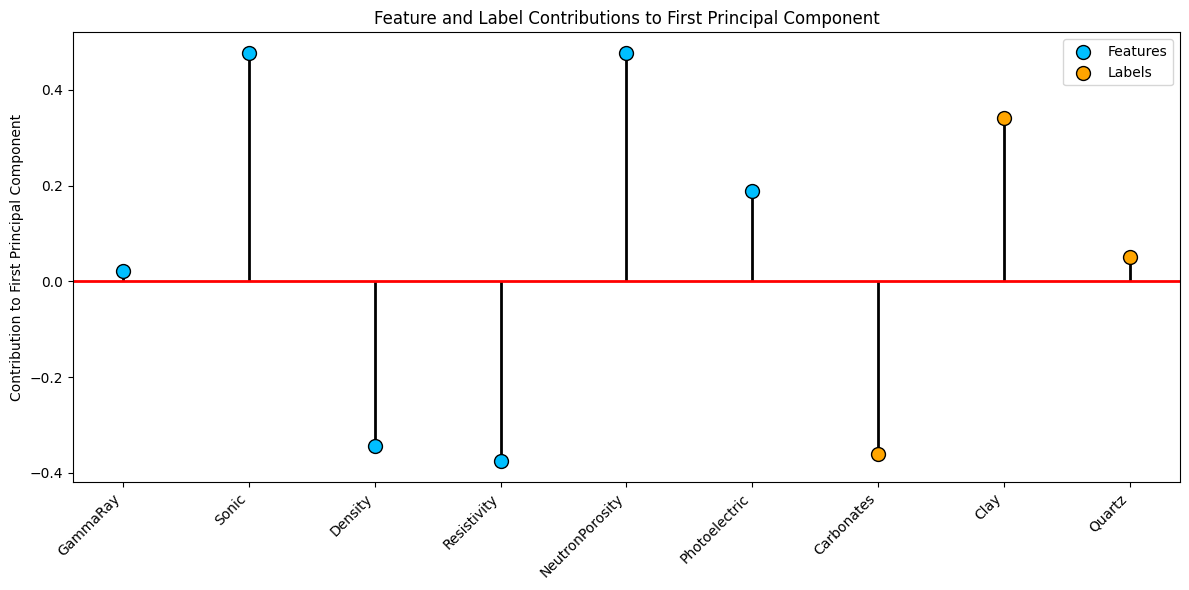

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the feature and label names
features = features
labels = ['Carbonates', 'Clay', 'Quartz']  # Adjust according to your target variables

# Combine features and labels for display purposes
components = features + labels

# Ensure data scaling for features and labels separately
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

# Fit and transform features and labels
X_train_scaled = scaler_features.fit_transform(X_train)
y_train_scaled = scaler_labels.fit_transform(y_train)

# Combine scaled features and labels for PCA
combined_train_scaled = np.hstack((X_train_scaled, y_train_scaled))

# Apply PCA to the combined training dataset
pca_combined = PCA()
combined_train_pca = pca_combined.fit_transform(combined_train_scaled)

# Get the first principal component contributions
pca_contributions = pca_combined.components_[0]

# Check the number of PCA components and ensure it matches the length of combined features and labels
if len(pca_contributions) != len(components):
    print(f"Warning: PCA components ({len(pca_contributions)}) do not match the number of features + labels ({len(components)}).")
    # Set the number of components to the minimum of PCA components and combined features + labels
    min_length = min(len(pca_contributions), len(components))
    pca_contributions = pca_contributions[:min_length]
    components = components[:min_length]

# Check lengths for consistency
print(f"Length of pca_contributions: {len(pca_contributions)}")
print(f"Length of features: {len(features)}")
print(f"Length of components: {len(components)}")

# Step 4: Plot the features and labels contributions to the first principal component
plt.figure(figsize=(12, 6))

# Plot feature contributions
plt.vlines(x=np.arange(len(features)), ymin=0, ymax=pca_contributions[:len(features)], color='black', lw=2)
plt.scatter(np.arange(len(features)), pca_contributions[:len(features)], color='deepskyblue', edgecolor='black', s=100, zorder=3, label='Features')

# Plot label contributions
plt.vlines(x=np.arange(len(features), len(components)), ymin=0, ymax=pca_contributions[len(features):], color='black', lw=2)
plt.scatter(np.arange(len(features), len(components)), pca_contributions[len(features):], color='orange', edgecolor='black', s=100, zorder=3, label='Labels')

# Add a baseline (y=0)
plt.axhline(0, color='red', lw=2)

# Set labels and title
plt.xticks(np.arange(len(components)), components, rotation=45, ha="right")
plt.ylabel('Contribution to First Principal Component')
plt.title('Feature and Label Contributions to First Principal Component')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

C:\Users\juanc\AppData\Local\Temp\ipykernel_35980\835648022.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


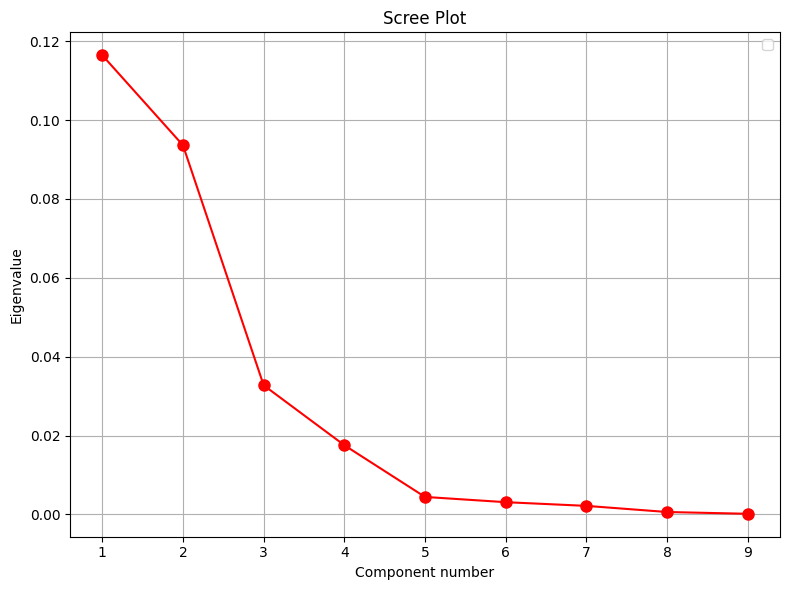

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming PCA has already been fitted (from your previous steps)
eigenvalues = pca.explained_variance_  # This gives you the eigenvalues for each component

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='red', linestyle='-', markersize=8)

# Labels and title
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

Principal Component 1: 0.4300 (Cumulative: 0.4300)
Principal Component 2: 0.3457 (Cumulative: 0.7757)
Principal Component 3: 0.1209 (Cumulative: 0.8966)
Principal Component 4: 0.0648 (Cumulative: 0.9614)
Principal Component 5: 0.0164 (Cumulative: 0.9778)
Principal Component 6: 0.0114 (Cumulative: 0.9892)
Principal Component 7: 0.0080 (Cumulative: 0.9972)
Principal Component 8: 0.0022 (Cumulative: 0.9994)
Principal Component 9: 0.0006 (Cumulative: 1.0000)


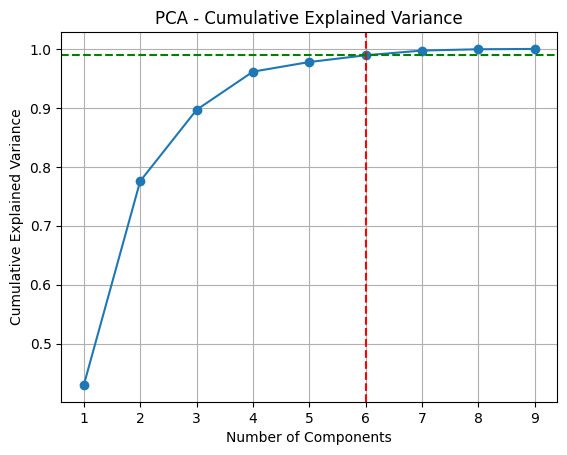

In [34]:
# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print the explained variance of each component and the cumulative variance
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"Principal Component {i+1}: {ev:.4f} (Cumulative: {cv:.4f})")

# Optionally plot the cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
#Plot a vertical line at 5 components and an horizontal line to see the explained variance
plt.axvline(x=6, color='red', linestyle='--')
plt.axhline(y=cumulative_variance[5], color='green', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

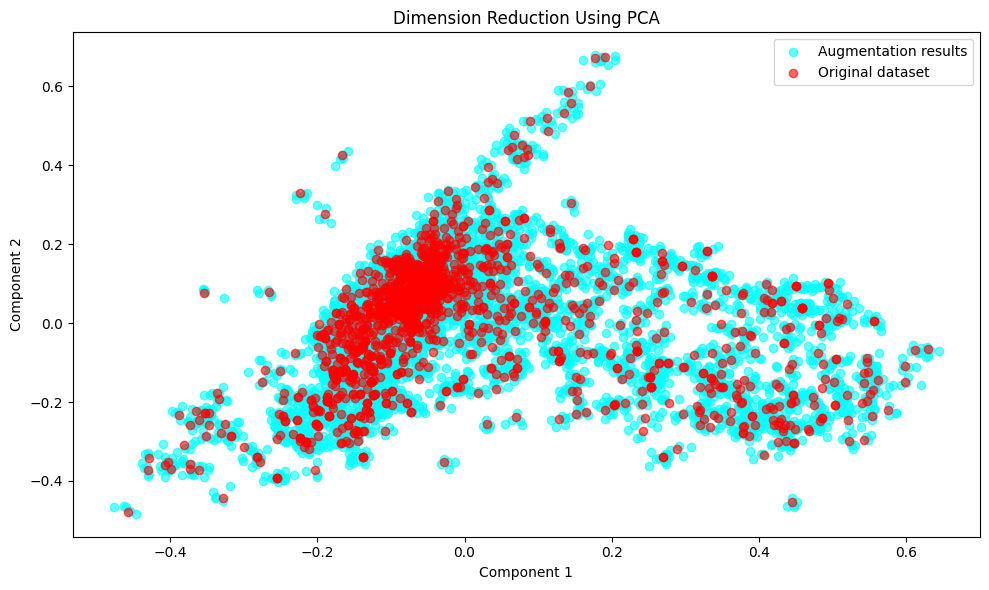

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Apply PCA to reduce both original and augmented datasets to 2 components
pca_2d = PCA(n_components=2)

# Assuming X_train_combined is the original + augmented data
X_train_combined_pca_2d = pca_2d.fit_transform(X_train_combined)

# Separate PCA results for original and augmented datasets
X_train_pca_2d = X_train_combined_pca_2d[:X_train.shape[0]]  # First part is the original data
X_train_aug_pca_2d = X_train_combined_pca_2d[X_train.shape[0]:]  # Remaining part is the augmented data

# Step 2: Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot augmented data in cyan
plt.scatter(X_train_aug_pca_2d[:, 0], X_train_aug_pca_2d[:, 1], color='cyan', label='Augmentation results', alpha=0.6)

# Plot original data in red
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], color='red', label='Original dataset', alpha=0.6)

# Step 3: Add labels and title
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Dimension Reduction Using PCA')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [36]:
import numpy as np
import pandas as pd

# Calculate weights based on 15-bin histogram for each target
def calculate_weights(y, bins=15):
    # Calculate the bin frequencies for each target variable
    weights = np.zeros(y.shape)
    for i, col in enumerate(y.columns):
        hist, bin_edges = np.histogram(y[col], bins=bins)
        max_freq = np.max(hist)
        bin_weights = np.zeros(len(y[col]))

        # Assign weights based on the inverse of the bin frequency
        for j in range(bins):
            bin_mask = (y[col] >= bin_edges[j]) & (y[col] < bin_edges[j+1])
            freq = hist[j]
            if freq > 0:
                bin_weights[bin_mask] = max_freq / freq

        # If the value equals the last bin edge (e.g., max value), set the weight
        bin_weights[y[col] == bin_edges[-1]] = max_freq / hist[-1]
        weights[:, i] = bin_weights

    return weights

# Calculate weights for the augmented training set
sample_weights_combined = calculate_weights(pd.DataFrame(y_train_combined, columns=labels))

# Check the shape of the weights array
print(f"Shape of sample weights for augmented data: {sample_weights_combined.shape}")

Shape of sample weights for augmented data: (8628, 3)


In [43]:
# Use a grid search approach with TQDM to find the best hyperparameters for batch size, dropout rate, L2 regularization, and the number of epochs.

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import warnings # Hide warnings
warnings.filterwarnings('ignore')

# Define the hyperparameters to tune

param_grid= {
    'optimizer': ['adam'],
    'dropout_rate': [0.1, 0.2, 0.3],
    'neurons': [32, 64],  # Más opciones
    'num_layers': [4],   # Profundidad variable
    'epochs': [50, 100],
    'batch_size': [16, 32, 64],
    'l2_reg': [0.001, 0.01],
    #'activation_type': ['leaky_relu', 'elu', 'swish']  # Diferentes activaciones
}

# Create a grid of parameters
param_list = list(ParameterGrid(param_grid))

# Function to create a model with different hyperparameters
def create_improved_model(dropout_rate=0.3, l2_reg=0.001, neurons=64, optimizer='adam', 
                         num_layers=4, activation_type='leaky_relu', use_residual=False):
    """
    Modelo mejorado con arquitectura flexible para predicción mineralógica
    
    Args:
        num_layers: Número de capas ocultas (3-6 recomendado)
        activation_type: 'leaky_relu', 'elu', 'swish'
        use_residual: Habilitar skip connections para redes más profundas
    """
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_combined_pca.shape[1],)))
    
    # Definir arquitectura adaptativa
    layer_sizes = []
    for i in range(num_layers):
        # Reducción más suave y adaptativa
        reduction_factor = (2 ** i) if i < 3 else (2 ** 3)  # Limitar reducción excesiva
        layer_size = max(neurons // reduction_factor, 16)  # Mínimo 16 neuronas
        layer_sizes.append(layer_size)
    
    # Construir capas ocultas
    for i, layer_size in enumerate(layer_sizes):
        # Capa densa con regularización
        model.add(layers.Dense(layer_size, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.BatchNormalization())
        
        # Activación flexible
        if activation_type == 'leaky_relu':
            model.add(layers.LeakyReLU(alpha=0.1))
        elif activation_type == 'elu':
            model.add(layers.ELU(alpha=1.0))
        elif activation_type == 'swish':
            model.add(layers.Activation('swish'))
        
        # Dropout adaptativo (menos en capas finales)
        dropout_adaptive = dropout_rate * (0.8 if i == len(layer_sizes)-1 else 1.0)
        model.add(layers.Dropout(dropout_adaptive))
    
    # Capa de salida con mejor inicialización
    model.add(layers.Dense(3, activation='sigmoid', 
                          kernel_initializer='glorot_uniform',
                          bias_initializer='zeros'))
    
    # Compilar con métricas adicionales
    model.compile(
        optimizer=optimizer, 
        loss='mae',
        metrics=['mse', 'mae']  # Para mejor monitoreo
    )
    return model

In [44]:
# Track the best hyperparameters and their performance
best_params = None
best_score = float('inf')

# Calculate mean weights across all target variables
mean_sample_weights_combined = sample_weights_combined.mean(axis=1)

In [45]:
# Perform grid search with TQDM tracking - CORREGIDO
for params in tqdm(param_list):
    # Unpack ALL parameters from param_grid
    optimizer = params['optimizer']
    dropout_rate = params['dropout_rate']
    neurons = params['neurons']
    epochs = params['epochs']
    batch_size = params['batch_size']
    l2_reg = params['l2_reg']
    num_layers = params['num_layers']  # ¡AGREGADO!
    # activation_type = params['activation_type']  # ¡AGREGADO!

    # Create and train the model with ALL parameters
    model = create_improved_model(
        dropout_rate=dropout_rate, 
        l2_reg=l2_reg, 
        neurons=neurons, 
        optimizer=optimizer,
        num_layers=num_layers,  # ¡AGREGADO!
        # activation_type=activation_type  # ¡AGREGADO!
    )

    # Train the model with sample weights for augmented data
    history = model.fit(
        X_train_combined_pca, 
        y_train_combined, 
        validation_data=(X_test_pca, y_test), 
        sample_weight=mean_sample_weights_combined,
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=0
    )
    
    # Evaluate the performance on the validation set
    val_loss = min(history.history['val_loss'])
    
    # Update the best parameters if this model is better
    if val_loss < best_score:
        best_score = val_loss
        best_params = params

# Output the best parameters
print(f"Best hyperparameters: {best_params}")
print(f"Best validation loss: {best_score}")

100%|██████████| 72/72 [45:16<00:00, 37.73s/it]  

Best hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 100, 'l2_reg': 0.001, 'neurons': 32, 'num_layers': 4, 'optimizer': 'adam'}
Best validation loss: 0.14438548684120178


In [46]:
#best_params = {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'l2_reg': 0.001, 'neurons': 32, 'optimizer': 'adam'}

In [48]:
# Extract ALL best hyperparameters - CORREGIDO
best_optimizer = best_params['optimizer']
best_dropout_rate = best_params['dropout_rate']
best_neurons = best_params['neurons']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']
best_l2_reg = best_params['l2_reg']
best_num_layers = best_params['num_layers']  # ¡AGREGADO!
# best_activation_type = best_params['activation_type']  # ¡AGREGADO!

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9188 - mae: 0.3300 - mse: 0.1544 - val_loss: 0.2993 - val_mae: 0.2399 - val_mse: 0.0750
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6775 - mae: 0.2404 - mse: 0.0871 - val_loss: 0.2615 - val_mae: 0.2057 - val_mse: 0.0588
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5944 - mae: 0.2068 - mse: 0.0699 - val_loss: 0.2362 - val_mae: 0.1839 - val_mse: 0.0515
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5634 - mae: 0.1931 - mse: 0.0632 - val_loss: 0.2161 - val_mae: 0.1673 - val_mse: 0.0465
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5403 - mae: 0.1831 - mse: 0.0579 - val_loss: 0.2023 - val_mae: 0.1569 - val_mse: 0.0439
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5262 - mae: 0.1778 - mse: 0.0558 - val_loss: 0.1951 - val_mae: 0.1529 - val_mse: 0.0432
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5126 - mae: 0.1740 - mse: 0.054

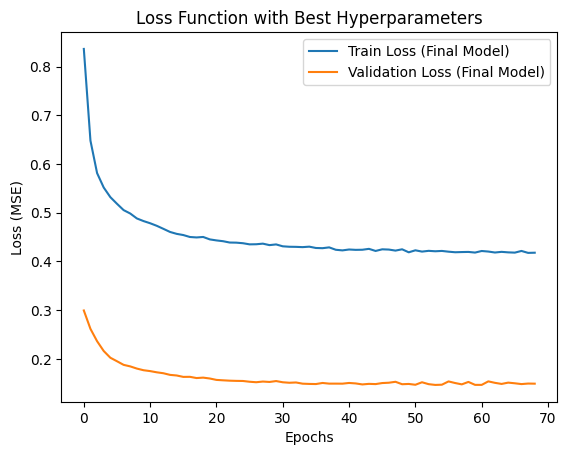

In [50]:
# Use the best hyperparameters identified from tuning - CORREGIDO
final_model = create_improved_model(
    dropout_rate=best_dropout_rate, 
    l2_reg=best_l2_reg,
    neurons=best_neurons,
    optimizer=best_optimizer,
    num_layers=best_num_layers,  # ¡AGREGADO!
    # activation_type=best_activation_type  # ¡AGREGADO!
)

pos = np.random.permutation(y_train_combined.shape[0])

# Opcional: Agregar early stopping para evitar overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

# En el training del modelo final:
final_history = final_model.fit(
    X_train_combined_pca[pos], 
    y_train_combined[pos],
    validation_data=(X_test_pca, y_test), 
    sample_weight=mean_sample_weights_combined[pos],
    epochs=best_epochs, 
    batch_size=best_batch_size, 
    callbacks=[early_stopping],  # ¡AGREGADO!
    verbose=1
)

# Plot the Loss for the Final Model
plt.plot(final_history.history['loss'], label='Train Loss (Final Model)')
plt.plot(final_history.history['val_loss'], label='Validation Loss (Final Model)')
plt.title('Loss Function with Best Hyperparameters')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [51]:
# We will calculate the normalized RMSE, MAE, and R² for each mineral.

# Predict on the test set with the final model
y_pred_final = final_model.predict(X_test_pca)

# Calculate metrics for the final model using column indices
rmse_calcite_final = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_final[:, 0]))
nrmse_calcite_final = rmse_calcite_final / (y_test[:, 0].max() - y_test[:, 0].min())

rmse_clay_final = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_final[:, 1]))
nrmse_clay_final = rmse_clay_final / (y_test[:, 1].max() - y_test[:, 1].min())

rmse_quartz_final = np.sqrt(mean_squared_error(y_test[:, 2], y_pred_final[:, 2]))
nrmse_quartz_final = rmse_quartz_final / (y_test[:, 2].max() - y_test[:, 2].min())

# MAE and nMAE for final model
mae_calcite_final = mean_absolute_error(y_test[:, 0], y_pred_final[:, 0])
nmae_calcite_final = mae_calcite_final / (y_test[:, 0].max() - y_test[:, 0].min())

mae_clay_final = mean_absolute_error(y_test[:, 1], y_pred_final[:, 1])
nmae_clay_final = mae_clay_final / (y_test[:, 1].max() - y_test[:, 1].min())

mae_quartz_final = mean_absolute_error(y_test[:, 2], y_pred_final[:, 2])
nmae_quartz_final = mae_quartz_final / (y_test[:, 2].max() - y_test[:, 2].min())

# R² for final model
r2_calcite_final = r2_score(y_test[:, 0], y_pred_final[:, 0])
r2_clay_final = r2_score(y_test[:, 1], y_pred_final[:, 1])
r2_quartz_final = r2_score(y_test[:, 2], y_pred_final[:, 2])

# Print final metrics
print(f"Final nRMSE for Carbonates: {nrmse_calcite_final:.2f}")
print(f"Final nRMSE for Clay: {nrmse_clay_final:.2f}")
print(f"Final nRMSE for Quartz: {nrmse_quartz_final:.2f}")

print(f"Final nMAE for Carbonates: {nmae_calcite_final:.2f}")
print(f"Final nMAE for Clay: {nmae_clay_final:.2f}")
print(f"Final nMAE for Quartz: {nmae_quartz_final:.2f}")

print(f"Final R² for Carbonates: {r2_calcite_final:.2f}")
print(f"Final R² for Clay: {r2_clay_final:.2f}")
print(f"Final R² for Quartz: {r2_quartz_final:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Final nRMSE for Carbonates: 0.22
Final nRMSE for Clay: 0.20
Final nRMSE for Quartz: 0.20
Final nMAE for Carbonates: 0.15
Final nMAE for Clay: 0.12
Final nMAE for Quartz: 0.15
Final R² for Carbonates: 0.28
Final R² for Clay: 0.45
Final R² for Quartz: 0.31


In [52]:
y_pred_final

array([[0.46143684, 0.08008908, 0.40339178],
       [0.19831544, 0.05605156, 0.74395263],
       [0.2966562 , 0.10128937, 0.56871283],
       ...,
       [0.7638106 , 0.01996552, 0.20897444],
       [0.24408604, 0.11615049, 0.6101476 ],
       [0.4890843 , 0.02490233, 0.496407  ]], dtype=float32)

In [53]:
y_pred_original= label_scaler.inverse_transform(y_pred_final)
y_test_original= label_scaler.inverse_transform(y_test)

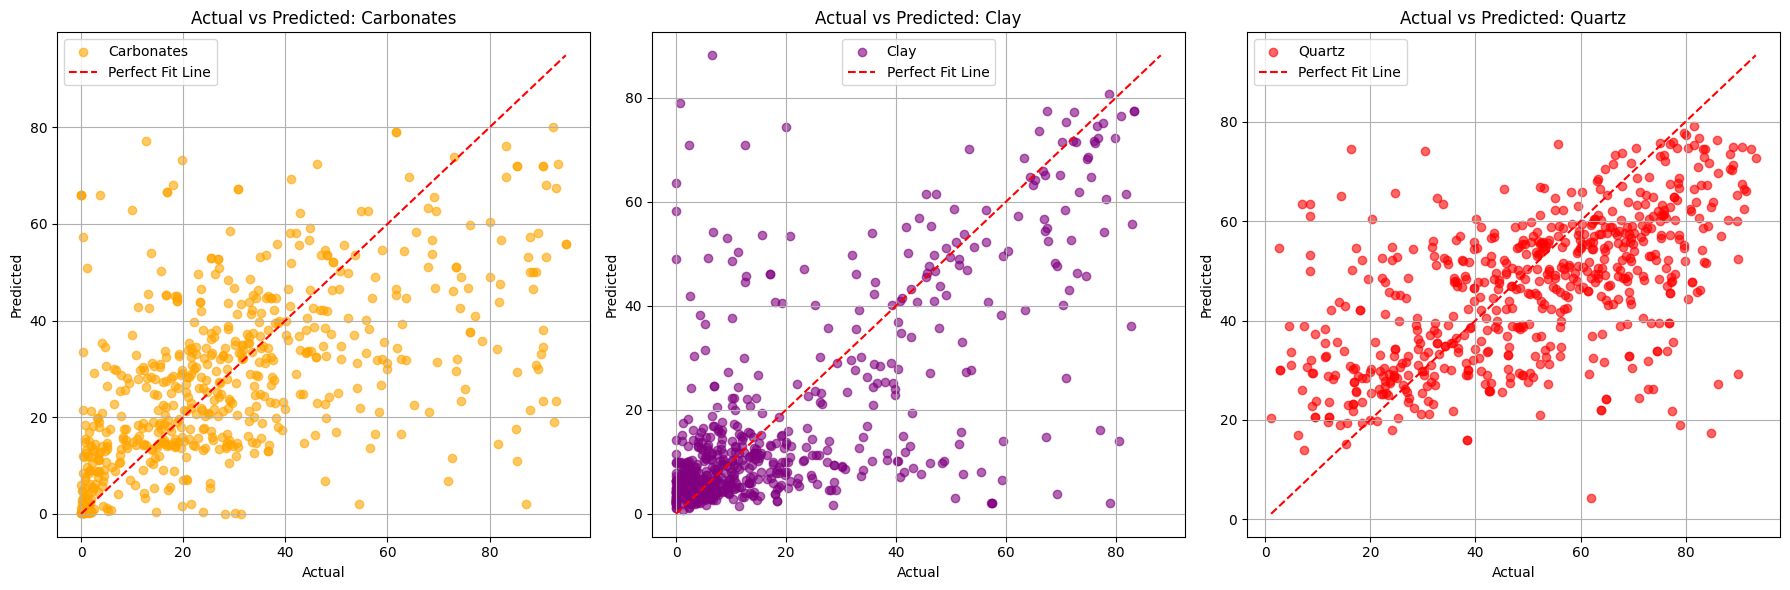

In [57]:
import matplotlib.pyplot as plt

minerals = ['Carbonates', 'Clay', 'Quartz']
colors = ['orange', 'purple', 'red']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (mineral, color) in enumerate(zip(minerals, colors)):
    ax = axes[i]
    ax.scatter(y_test_original[:, i], y_pred_original[:, i], label=f'{mineral}', color=color, alpha=0.6)
    # Ajusta el rango de la diagonal según los valores reales
    min_val = min(y_test_original[:, i].min(), y_pred_original[:, i].min())
    max_val = max(y_test_original[:, i].max(), y_pred_original[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit Line')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs Predicted: {mineral}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
